# Data Science Workflow

This is a notebook for testing all of the functions to go through an entire data science workflow of running NLP on chosen subreddits.

**Future**
- DF functions should be removed from workflow and imported using a class.
- Multiple example DS outcomes would be nice.

---

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import wordcloud
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import databases
import dataloader

In [2]:
# subreddit_list = ['css', 'html', 'javascript', 'php', 'perl', 'java', 'datascience', 'machinelearning', 'etl', 'python']

In [3]:
subreddit_list = ['css','html','datascience','machinelearning']

In [4]:
df = dataloader.data_selector(subreddit_list, 'scrape')

Scraping subreddit "css"
Success. 922 total posts for "css"
Scraping subreddit "html"
Success. 973 total posts for "html"
Scraping subreddit "datascience"
Success. 900 total posts for "datascience"
Scraping subreddit "machinelearning"
Success. 988 total posts for "machinelearning"


In [5]:
subreddit_list = [sub for sub in subreddit_list if sub in df.subreddit.unique()]

In [6]:
subreddit_list

['css', 'html', 'datascience', 'machinelearning']

In [7]:
df = dataloader.subreddit_encoder(df)

Topic dict to make sure: {'css': 0, 'html': 1, 'datascience': 2, 'machinelearning': 3}


In [8]:
df.sample(10)

,title,subreddit,date,sub_code
2680,Why you should be worried about infectious dis...,datascience,2020-03-16,2
1216,"How to apply CSS to specific Table Header ""mes...",html,2020-03-16,1
598,CSS Selector - how can I only select p element...,css,2020-03-16,0
2005,How long will the data analytics trend last ?,datascience,2020-03-16,2
581,Flexbox Properties Playground,css,2020-03-16,0
1668,Option to resize text for users.,html,2020-03-16,1
47,Beginner in need of urgent help,css,2020-03-16,0
1396,Help with Using Website to Shorten Links,html,2020-03-16,1
990,How to put a list inside a rectangle ?,html,2020-03-16,1
1151,Any advice for setting up a site that will be ...,html,2020-03-16,1


In [9]:
X = df['title']
y = df['sub_code']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

In [21]:
useless_words = set(['using', 'help', 'new', 'data', 'science', 'machine', 'learning', 'use', 'need'])

custom_stop_words = ENGLISH_STOP_WORDS.union(subreddit_list, useless_words)

In [22]:
pipe = Pipeline([('count_vec', CountVectorizer()), ('lr', LogisticRegression())])

In [23]:
pipe_params = {
                'count_vec__max_features': [4000],
                'count_vec__max_df': [.3],
                'count_vec__ngram_range': [(1,2)],
                'count_vec__stop_words': [custom_stop_words],
                'count_vec__min_df': [3],
                'lr__penalty': ['l2'],
                'lr__C': [5]
                }

In [24]:
model = GridSearchCV(pipe, param_grid=pipe_params, cv=5, verbose=1, n_jobs=-1)

In [25]:
model.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
/Users/chris/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('count_vec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                       

In [26]:
model.best_params_

{'count_vec__max_df': 0.3,
 'count_vec__max_features': 4000,
 'count_vec__min_df': 3,
 'count_vec__ngram_range': (1, 2),
 'count_vec__stop_words': frozenset({'a',
            'about',
            'above',
            'across',
            'after',
            'afterwards',
            'again',
            'against',
            'all',
            'almost',
            'alone',
            'along',
            'already',
            'also',
            'although',
            'always',
            'am',
            'among',
            'amongst',
            'amoungst',
            'amount',
            'an',
            'and',
            'another',
            'any',
            'anyhow',
            'anyone',
            'anything',
            'anyway',
            'anywhere',
            'are',
            'around',
            'as',
            'at',
            'back',
            'be',
            'became',
            'because',
            'become',
            'becomes',
    

In [27]:
print(f'Best Modeling Score: {model.best_score_}')

print(f'Train Score: {model.score(X_train, y_train)}')

print(f'Test Score: {model.score(X_test, y_test)}')

Best Modeling Score: 0.6171988722458206
Train Score: 0.9298554811420514
Test Score: 0.6152219873150105


In [28]:
# model is GridSearchCV
# best_estimator is Pipeline
# named_steps is the steps in the pipeline
# count_vec is the FITTED 

features_data = model.best_estimator_.named_steps.count_vec.transform(X).toarray()
features_columns = model.best_estimator_.named_steps.count_vec.get_feature_names()
features_df = pd.DataFrame(data=features_data, columns=features_columns)

In [29]:
### CHECK ### does this function work with tfidf, or just count vec?
###HELP### display scale is out of proportion when only using 3 features, 2 columns if features below X value?
def plot_most_common(df, features_df, num_features=20, standardize=False, include_combined=False):
    '''
    Plots the most common features for each subreddit in the DataFrame
    
    Parameters:
    
    df: original DataFrame
    
    features_df: should be output from transformer on df
        
        Example:
        features_df = pd.DataFrame(
                                data={transformer}.transform(X).toarray(),
                                columns={transformer}.get_feature_names())
    
    num_features: number of most common features to plot for each subreddit
    
    standardize: put all of the plots on the same scale
    
    combined: include a plot of the most common features of all of the subreddits combined
    
    Returns:
    
    plots
    
    '''

    fig, ax = plt.subplots(ncols=1, 
                           nrows=len(subreddit_list) + int(1 if include_combined else 0), 
                           figsize=(15, num_features/1.5*len(subreddit_list)))

    for subplot_idx, sub in enumerate(subreddit_list):
        sub_features = features_df.loc[df['subreddit'] == sub]
        sub_top_words = sub_features.sum().sort_values(ascending=False).head(num_features)[::-1]
        sub_top_words.plot(kind='barh', ax=ax[subplot_idx])
        ax[subplot_idx].set_title(f'{num_features} Most Common Words for {sub.upper()}', fontsize=16)
        if standardize:
            max_occurence = features_df.sum().max()
            ax[subplot_idx].set_xlim(0,max_occurence)

    if include_combined:
        most_common = features_df.sum().sort_values(ascending=False).head(num_features)[::-1]
        most_common.plot(kind='barh', ax=ax[subplot_idx+1])
        ax[subplot_idx+1].set_title(f'{num_features} Most Common Words for {subreddit_list}')
        if standardize:
            max_occurence = features_df.sum().max()
            ax[subplot_idx+1].set_xlim(0,max_occurence)
    plt.tight_layout()

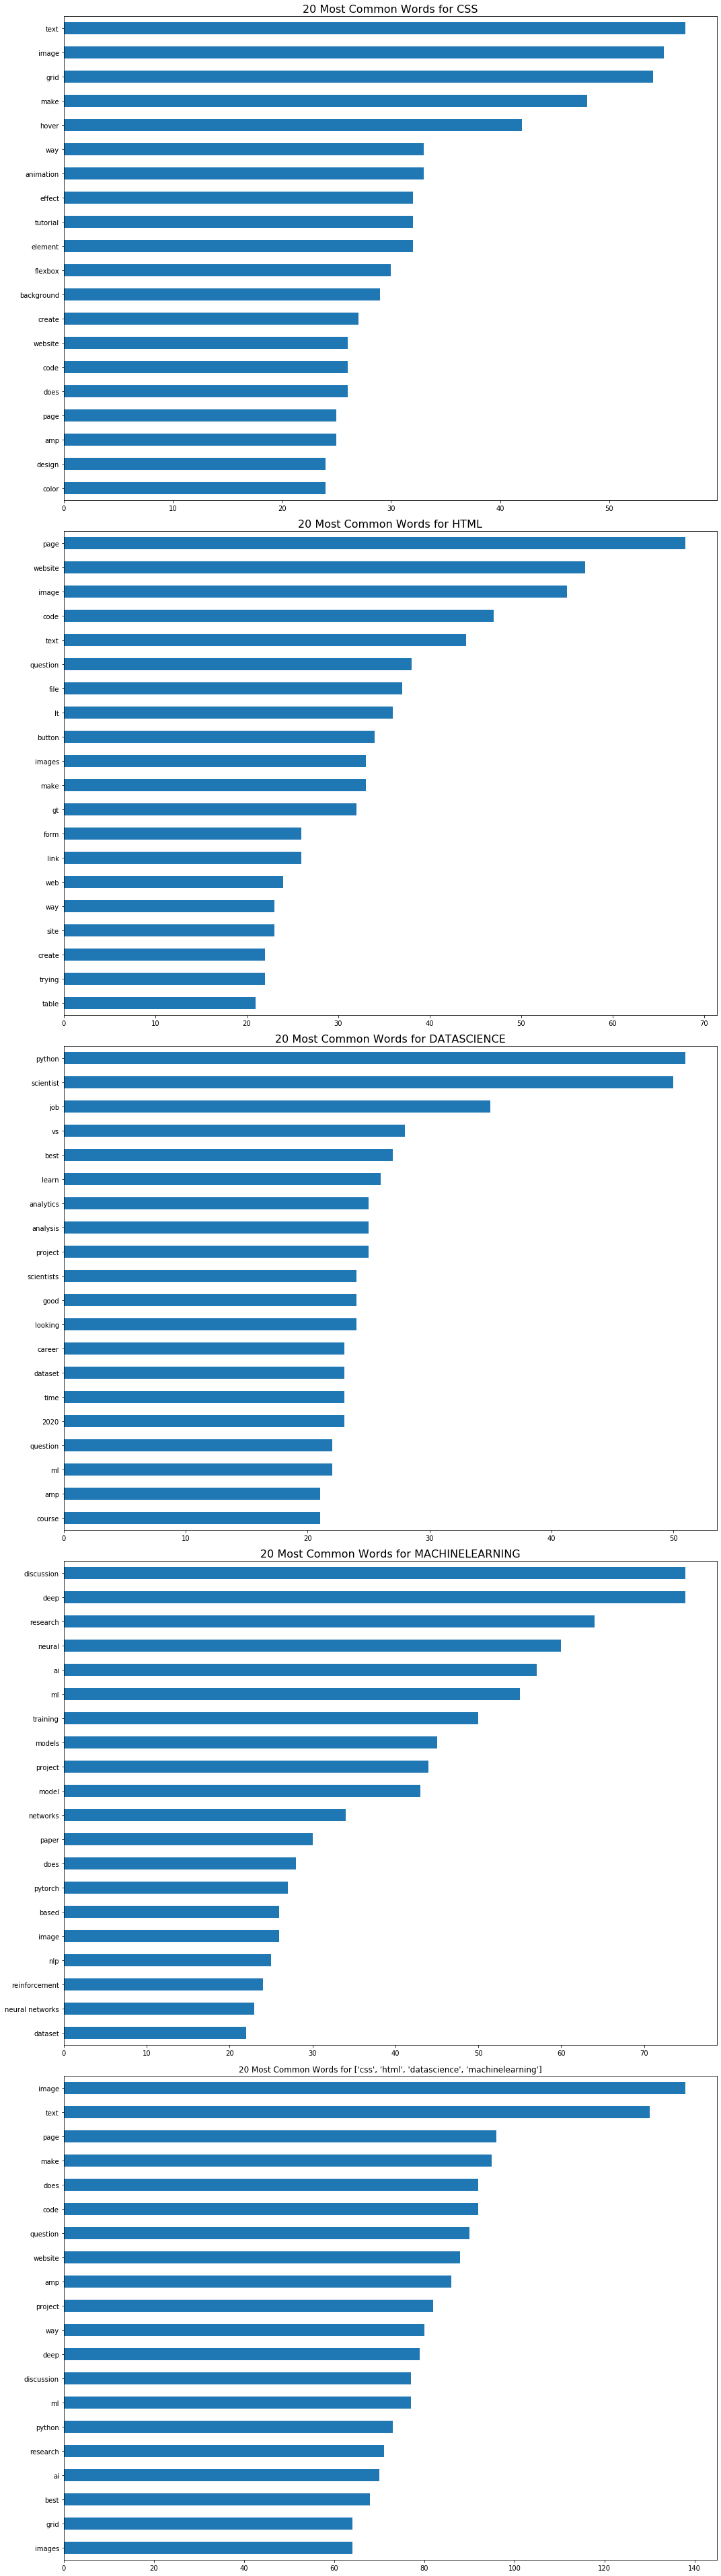

In [30]:
plot_most_common(df, features_df, num_features=20, include_combined=True)

## Feature Importance Coefficients

In [31]:
###HELP### I don't think this is working right
###HELP### coefficients don't make sense for the entire dataset, would need to do one for each thing

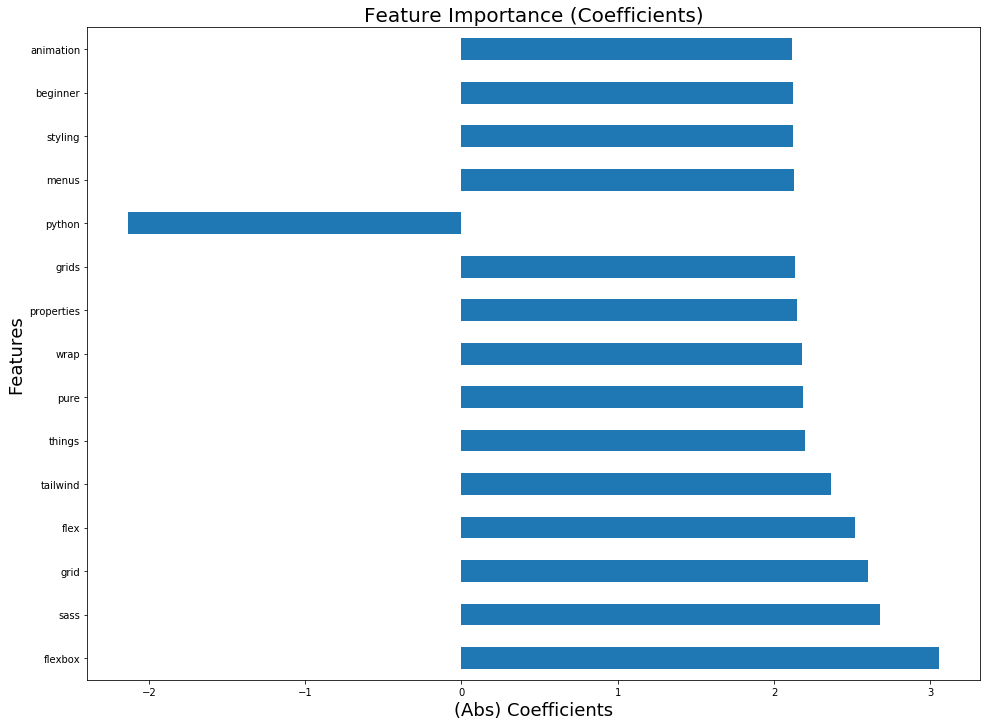

In [32]:
###NOTE### coefficients only for lr and etc etc etc...
###NOTE### coefficients only for two subreddits


# [-1][1] for last step (estimator)(instantiation)
# coef_[0]because I don't know why
coefs = model.best_estimator_.steps[-1][1].coef_[0]




plt.figure(figsize=(16, 12))
plt.title('Feature Importance (Coefficients)', fontsize=20)
plt.ylabel('Features', fontsize=18)
plt.xlabel('(Abs) Coefficients', fontsize=18)

coef_df = pd.DataFrame(data=[coefs], columns=features_columns).T
coef_df['abs_coef'] = coef_df[0].abs()
coef_df.sort_values('abs_coef', ascending=False)[0].head(15).plot(kind='barh');

# coef_kill = coef_df.sort_values('abs_coef', ascending=False)[0].head(500).index

# coef_kill


# my_stops.extend(coef_kill)

In [33]:
from itertools import combinations

In [34]:
def make_pairs(subreddit_list):
    '''
    Makes combination pairs of subreddits from subreddit_list
    '''
    if len(subreddit_list) > 2:
            return list(combinations(subreddit_list,2))
    return subreddit_list

In [36]:
pairs = make_pairs(subreddit_list)
pairs

[('css', 'html'),
 ('css', 'datascience'),
 ('css', 'machinelearning'),
 ('html', 'datascience'),
 ('html', 'machinelearning'),
 ('datascience', 'machinelearning')]

In [39]:
def plot_most_common_pairs(df, features_df, pairs, num_features=20):
    '''
    Plots the most common features for each subreddit in the DataFrame
    
    Parameters:
    
    df: original DataFrame
    
    features_df: should be output from transformer on df
        
        Example:
        features_df = pd.DataFrame(
                                data={transformer}.transform(X).toarray(),
                                columns={transformer}.get_feature_names())
    
    num_features: number of most common features to plot for each subreddit
    
    Returns:
    
    plots
    
    '''
    fig, ax = plt.subplots(ncols=2, 
                           nrows=len(pairs), 
                           figsize=(16,num_features/3*len(pairs)))

    for i, pair in enumerate(pairs):

        # features for each pair
        feats_0 = features_df.loc[(df['subreddit'] == pair[0])]
        feats_1 = features_df.loc[(df['subreddit'] == pair[1])]
        # combined
        common_feats = feats_0.append(feats_1)
        # this is the most common between the two
        most_common = common_feats.sum().sort_values(ascending=False).head(num_features)[::-1]
        # plot
        feats_0[most_common.index].sum().plot.barh(ax=ax[i, 0], color='navy')
        feats_1[most_common.index].sum().plot.barh(ax=ax[i, 1], color='orange')
        ax[i, 0].set_title(f'Top {num_features} - {pair} \nSub: {pair[0].upper()}', fontsize=16, wrap=True)
        ax[i, 1].set_title(f'Top {num_features} - {pair} \nSub: {pair[1].upper()}', fontsize=16, wrap=True)
        max_occurence = common_feats.sum().max()
        ax[i, 0].set_xlim(0,max_occurence)
        ax[i, 1].set_xlim(0,max_occurence)
    plt.tight_layout()

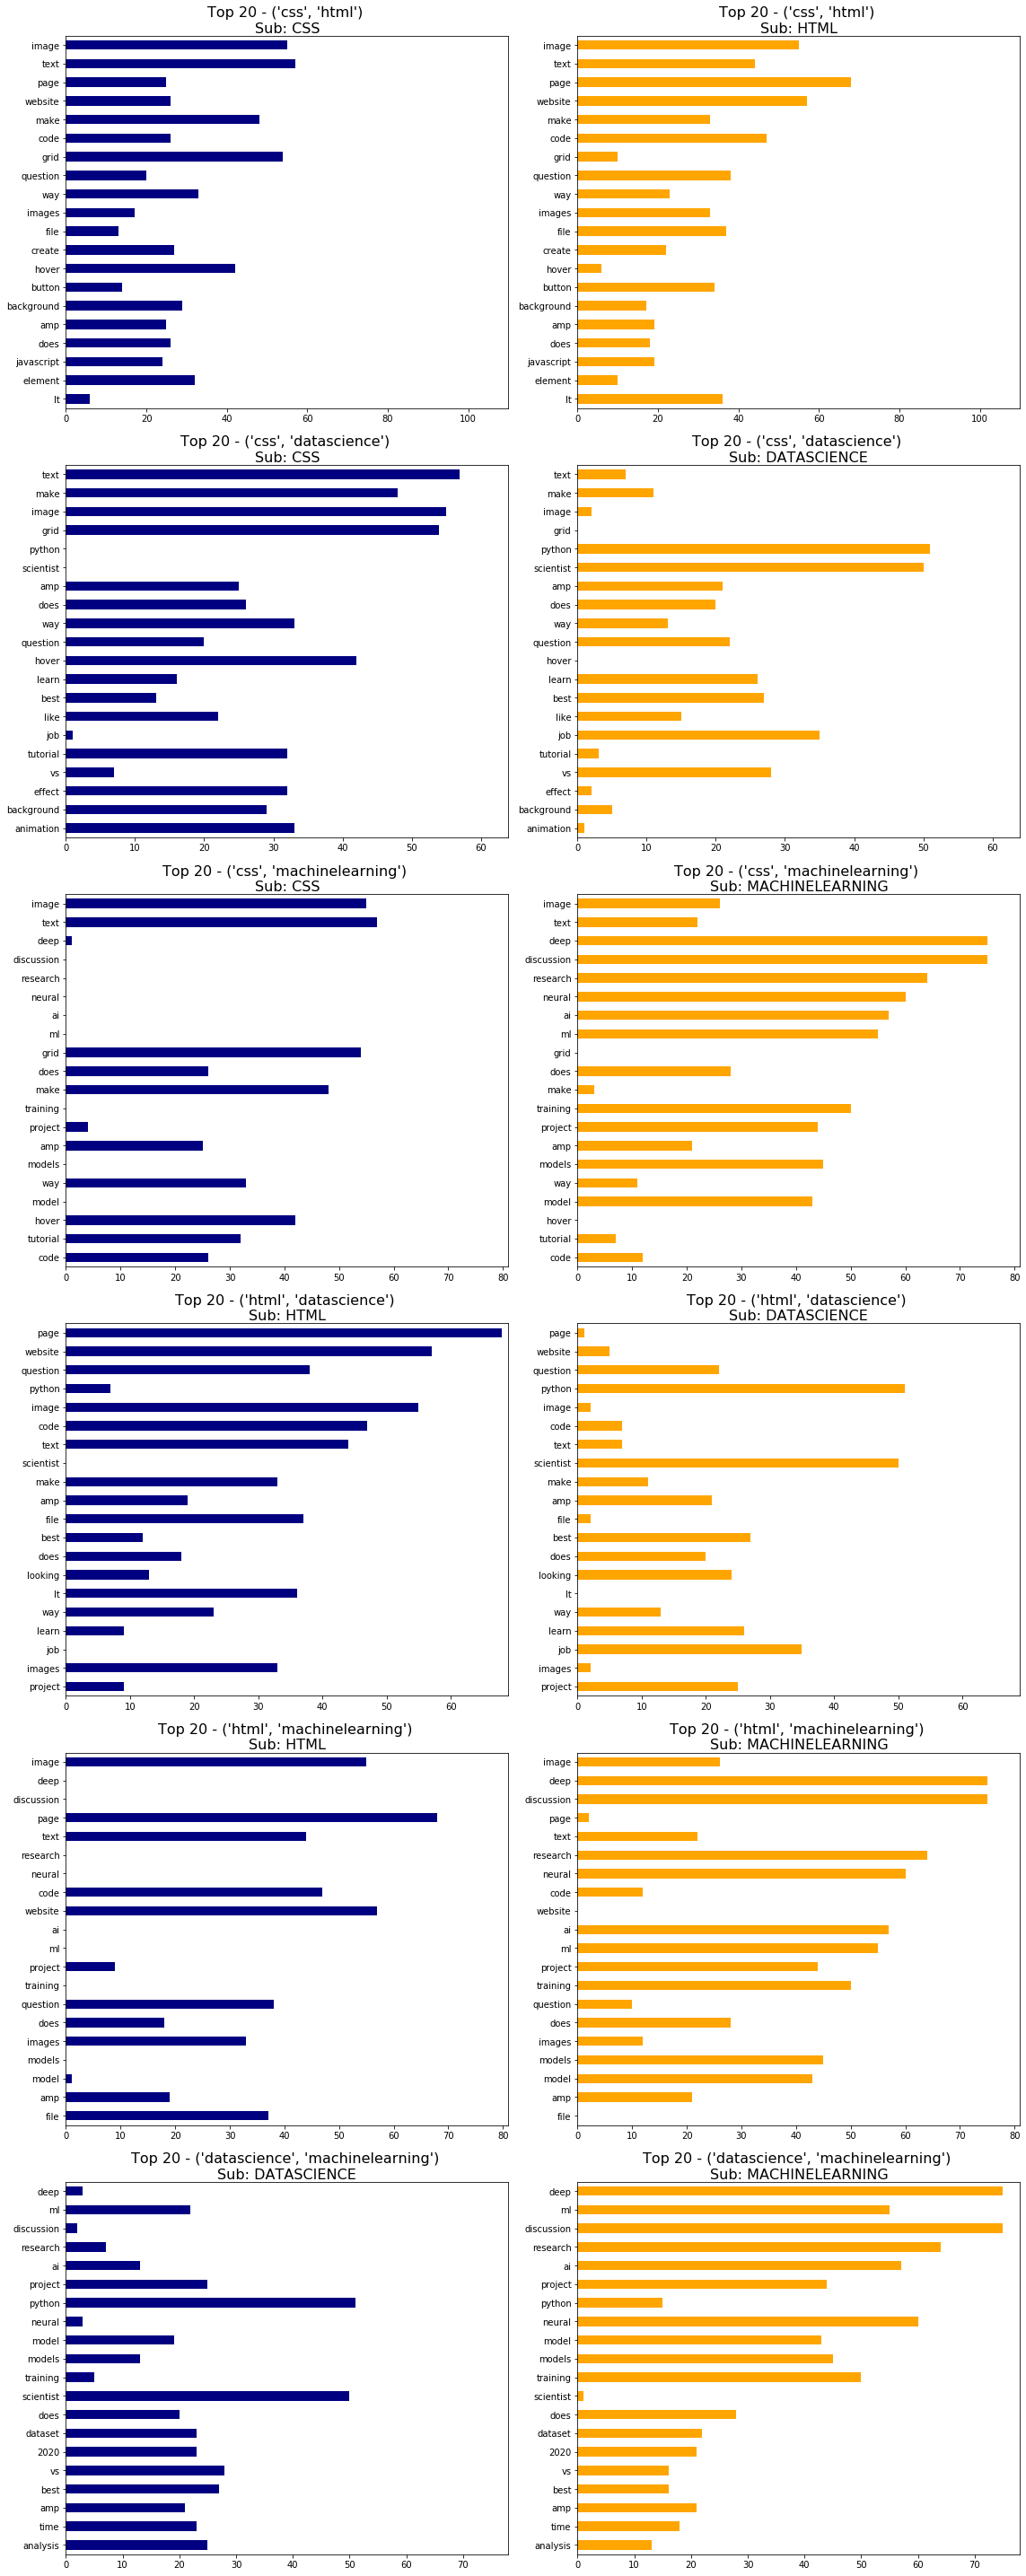

In [40]:
plot_most_common_pairs(df, features_df, pairs)

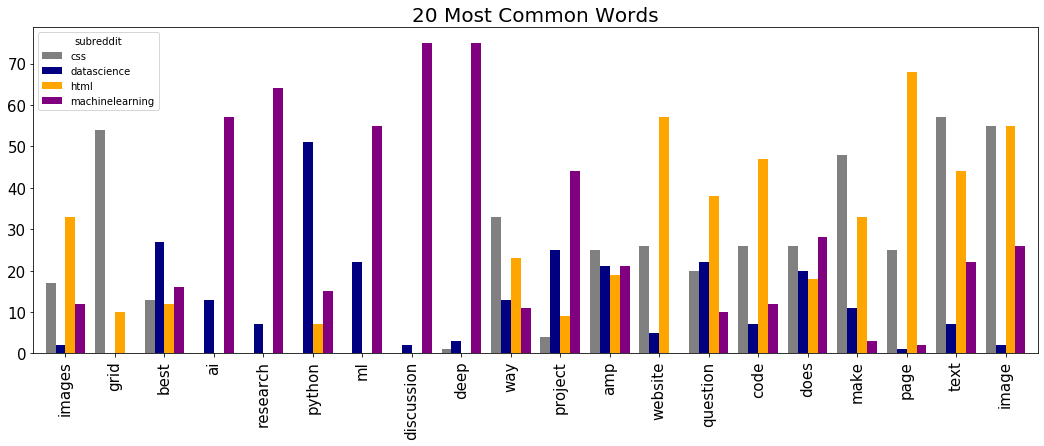

In [41]:
fig, ax = plt.subplots(figsize=(18,6))

most_common = features_df.sum().sort_values(ascending=False).head(20)[::-1]
groups = features_df.groupby(df['subreddit']).sum()[most_common.index].T.head(20)
plt.title('20 Most Common Words', fontsize=20)

groups.plot.bar(
                ax=ax,
                width=.8,
                # set style for colors instead of have to choose individually
                color=['gray','navy','orange','purple','red'],
                fontsize=15,
                );

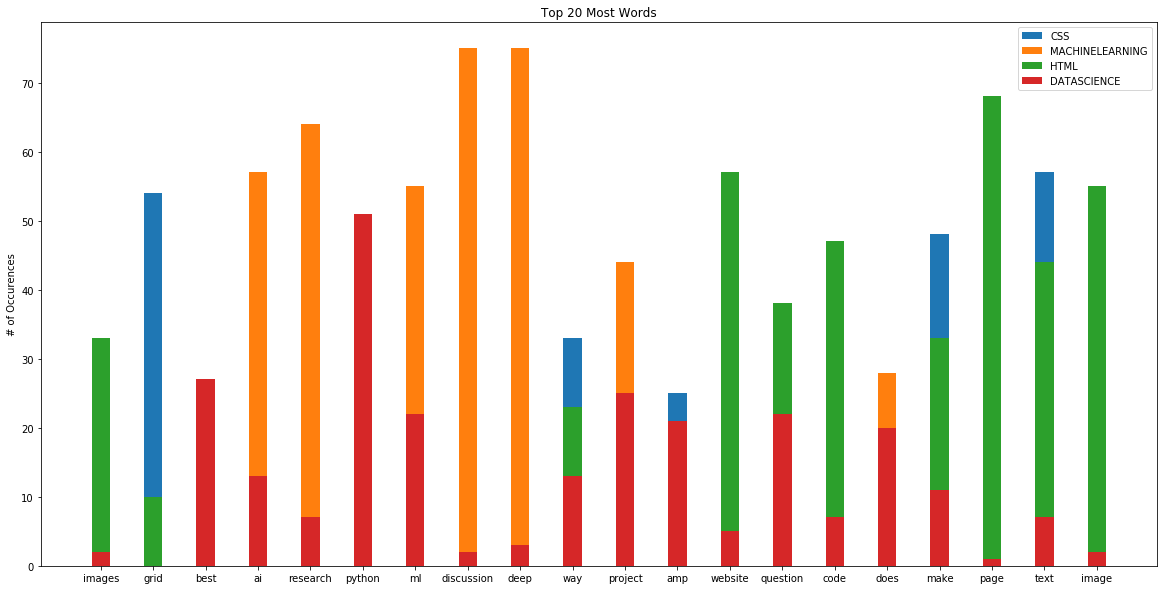

In [42]:
labels = groups.index
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(20,10))

# for sub in groups.columns:
#     ax.bar(labels, groups.sub, width, label=sub)
    
ax.bar(labels, groups.css, width, label='CSS',)
ax.bar(labels, groups.machinelearning, width, label='MACHINELEARNING')
ax.bar(labels, groups.html, width, label='HTML')
ax.bar(labels, groups.datascience, width, label='DATASCIENCE')

ax.set_ylabel('# of Occurences')
ax.set_title('Top 20 Most Words')
ax.legend()

plt.show()

# Word Clouds!!!

### Entire dataset

In [45]:
def make_cloud(X, height=400, width=700, max_words=50, split=None, labels=None):
        '''
        Inputs:
        X: text input
        height: height of each wordcloud
        width: width of each wordcloud
        max_words: max words for each wordcloud
        split: if True, wordcloud for each subreddit
        labels: must provide list of labels if split=True, to generate a wordcloud for each label
        '''
        wc = wordcloud.WordCloud(max_words=max_words, 
                                 width=width, 
                                 height=height, 
                                 background_color='white',
                                )
        if split:
            fig = plt.figure(figsize=(14, 6*len(labels)))
            for i, label in enumerate(labels):
                ax = fig.add_subplot(len(labels),1,i+1)
                cloud = make_cloud(X=df[df['subreddit'] == label]['title'])


                ax.set_title(label.upper(), fontdict={'fontsize': 24})
                ax.imshow(cloud)
                ax.axis('off')

        else:
            cloud = wc.generate(X.str.cat())
            return cloud.to_image()



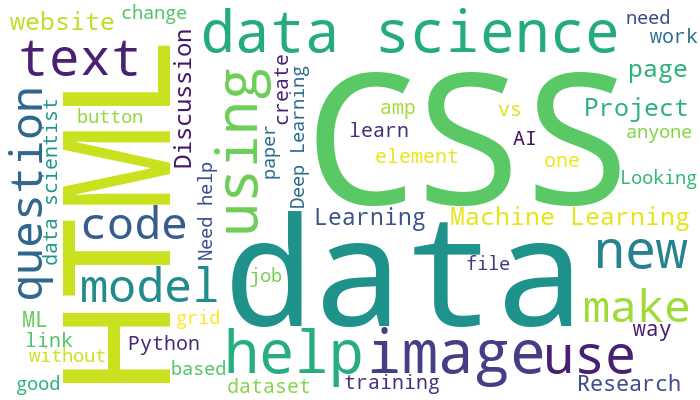

In [46]:
make_cloud(X)

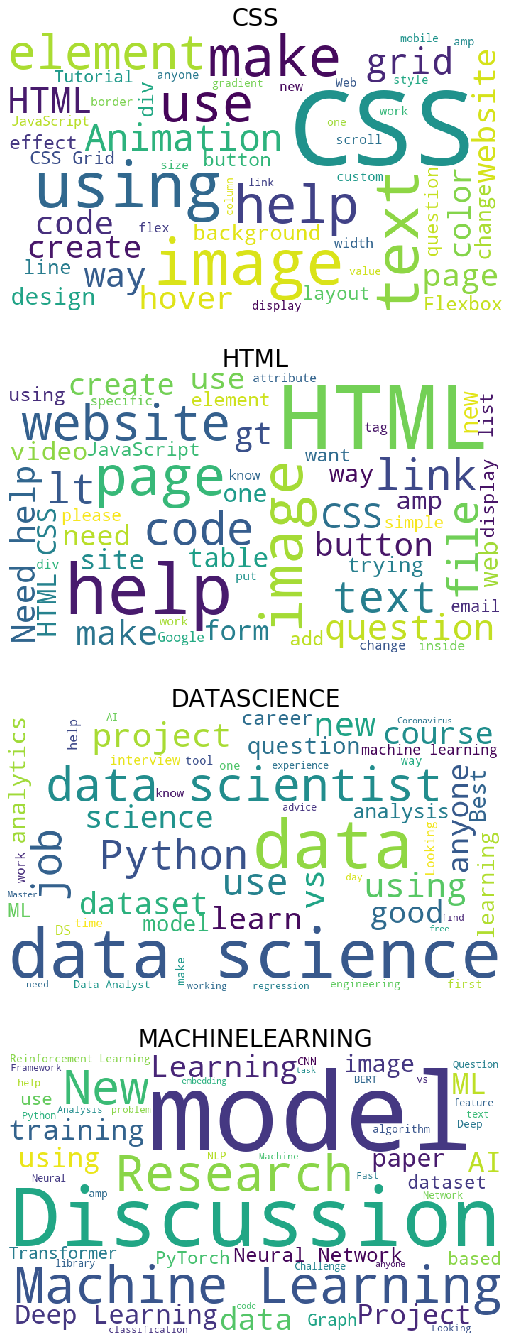

In [47]:
make_cloud(X, split=True, labels=subreddit_list)

## Confusion Matrix

In [48]:
y_pred = model.predict(X_test)

In [49]:
cm = confusion_matrix(y_test, y_pred)

In [50]:
df_cm = pd.DataFrame(cm, columns=subreddit_list, index=subreddit_list)
df_cm

,css,html,datascience,machinelearning
css,143,79,6,15
html,52,154,18,12
datascience,12,48,122,51
machinelearning,5,18,48,163


In [51]:
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

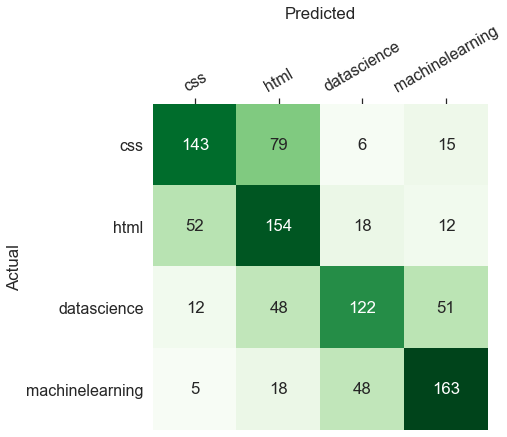

In [56]:
fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.4, )#for label size
sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, cmap='Greens', ax=ax)
fontdict={'fontsize': 16}
ax.set_yticklabels(labels=subreddit_list, rotation='horizontal', fontdict=fontdict)
ax.set_xticklabels(labels=subreddit_list, rotation=30, fontdict=fontdict)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

In [60]:
mcm = multilabel_confusion_matrix(y_test, y_pred)
mtn = mcm[:, 0, 0]
mtp = mcm[:, 1, 1]
mfn = mcm[:, 1, 0]
mfp = mcm[:, 0, 1]
print(mcm)

[[[634  69]
  [100 143]]

 [[565 145]
  [ 82 154]]

 [[641  72]
  [111 122]]

 [[634  78]
  [ 71 163]]]


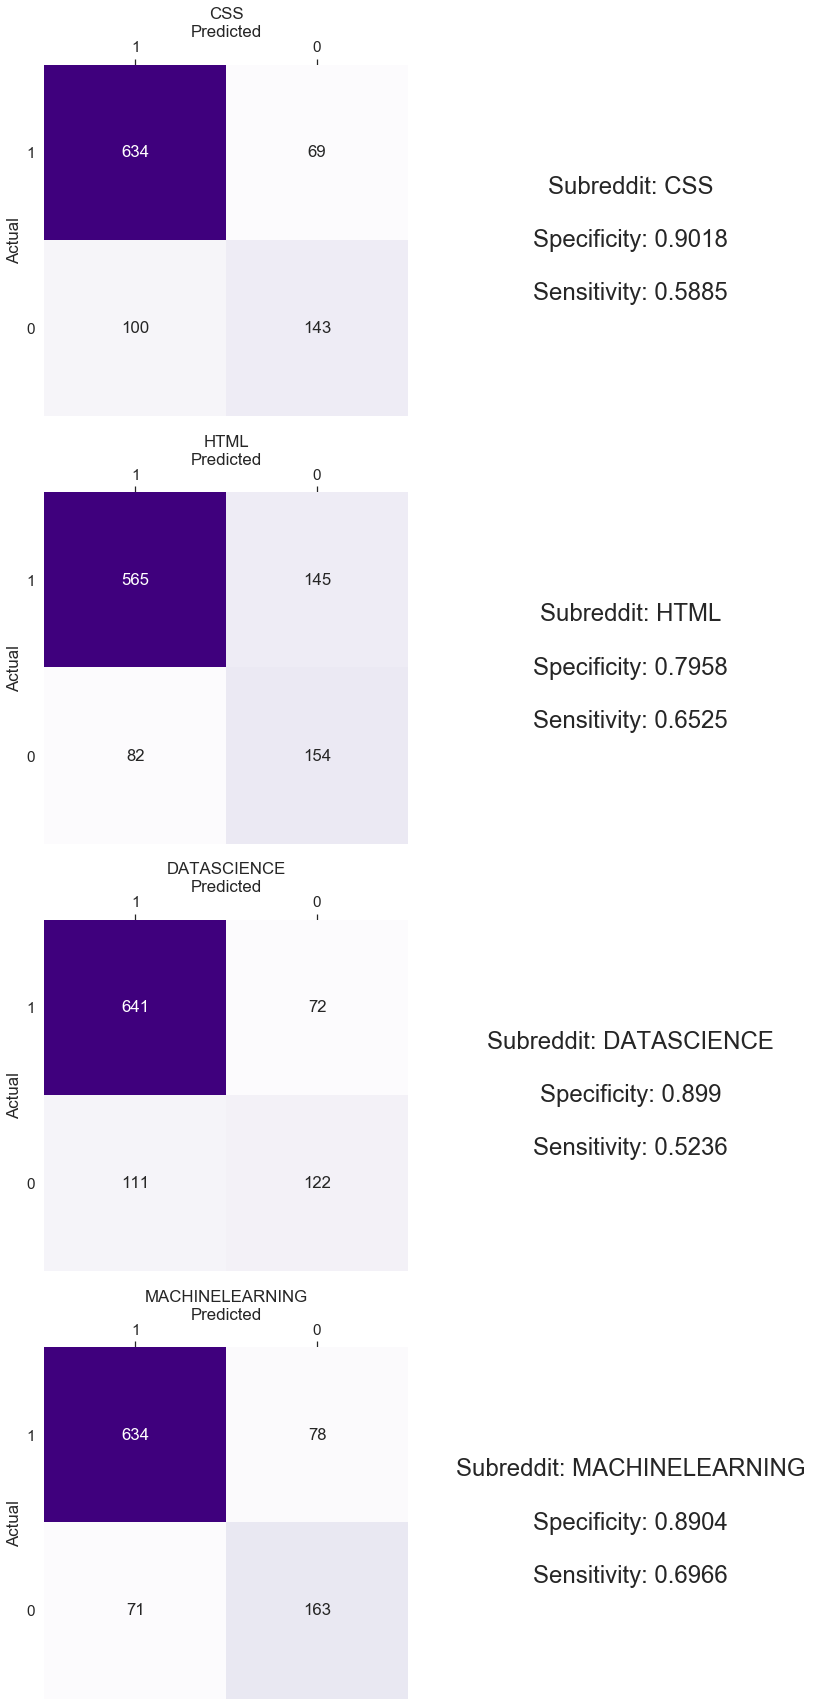

In [61]:
fig, ax = plt.subplots(ncols=2, nrows=len(subreddit_list),
                       figsize=(12, 6*len(subreddit_list)))

for i, cm in enumerate(mcm):
    df_cm = pd.DataFrame(cm)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sns.heatmap(df_cm, annot=True, fmt="d", cbar=False,
                cmap='Purples', ax=ax[i, 0])

    ax[i, 0].set_yticklabels(labels=[1, 0], rotation='horizontal')
    ax[i, 0].set_xticklabels(labels=[1, 0])
    ax[i, 0].xaxis.tick_top()
    ax[i, 0].xaxis.set_label_position('top')
    ax[i, 0].set_title(subreddit_list[i].upper())

    tn, fp, fn, tp = cm.ravel()
    specif = tn / (tn + fp)

    sens = tp / (tp + fn)
    box_text = f'''Subreddit: {subreddit_list[i].upper()}\n\nSpecificity: {round(specif,4)}\n\nSensitivity: {round(sens,4)}'''
    ax[i, 1].text(0.5, 0.5, box_text, horizontalalignment='center',
                  verticalalignment='center', fontsize=24)
    ax[i, 1].set_axis_off()


plt.tight_layout()

In [62]:
print(classification_report(y_test, y_pred, digits=3, target_names=subreddit_list))

                 precision    recall  f1-score   support

            css      0.675     0.588     0.629       243
           html      0.515     0.653     0.576       236
    datascience      0.629     0.524     0.571       233
machinelearning      0.676     0.697     0.686       234

       accuracy                          0.615       946
      macro avg      0.624     0.615     0.616       946
   weighted avg      0.624     0.615     0.616       946



### ROC AUC Score

<h1>TODO:</h1>

1. Make it have the roc for each sub, have to get into the original df where subname equals indexes?
2. Plot confusion matrix
3. Make a notebook to test the confusion matrixes one by one with each individual model.

In [ ]:
y_test.index

In [ ]:
auc = roc_auc_score(y_test, predictions)
auc

### ROC AUC Curve

In [ ]:
probs = model.predict_proba(X_test)[:,1]

In [ ]:
# not multiclass
fpr, tpr, thresholds = roc_curve(y_test, probs)

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc})', color='r', marker='D')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)', size=16)
plt.ylabel('True Positive Rate (Sensitivity)', size=16)
plt.title('ROC Curve', size=20)
plt.legend(fontsize=14);

# Histograms!

In [ ]:
# Create figure.
plt.figure(figsize = (10,7))

# Create histogram of observations.
plt.hist(probs, bins=25, color='b')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18);

In [ ]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
hst0 = plt.hist(lr_probs[y_test == 0],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Technology',)

hst1 = plt.hist(lr_probs[y_test == 1],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Science')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = max(hst1[0].max(), hst0[0].max()), # Max of the two highest respective hist values
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Science)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

# Thanks to Matt Brems for the colorful graphs! :)